In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data

In [ ]:
import os
import csv

samples = []
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

samples = samples[1:]

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

from scipy import misc
import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+ batch_sample[0].split('/')[-1]
                center_image = misc.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [2]:
    
lines = []
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []
correction = 0.2

for row in lines[1:]:
    steering_center = float(row[3])
    source_path = line[0]

    steering_left = steering_center + correction
    steering_right = steering_center - correction

    filename = source_path.split('/')[-1]
    for name, steer in zip(row[:3], [steering_center, steering_left, steering_right]):
        file_path = '../data/' + name.strip()
#         left, right = process_image(cv2.imread(file_path), steer)
#         images.extend([np.asarray(left[0]), np.asarray(right[0])])
#         measurements.extend([left[1], right[1]])
        images.append(misc.imread(file_path))
        measurements.append(steer)
        


X_train = np.array(images)
y_train = np.array(measurements)

In [3]:
print("Shape of X_train is:", X_train.shape)
print("Shape of y_train is:", y_train.shape)

Shape of X_train is: (24108, 160, 320, 3)
Shape of y_train is: (24108,)


# Preprocess Data

# Train Model

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D
from keras.layers import Cropping2D
from keras.models import Model
import matplotlib.pyplot as plt

model = Sequential()
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(65, 320, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation="relu"))
# model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation="relu"))
# model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
# model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=256, nb_epoch=20, shuffle=True)

model.save('model.h5')

Using TensorFlow backend.


Train on 19286 samples, validate on 4822 samples
Epoch 1/20
19286/19286 [==============================] - 47s - loss: 0.1199 - val_loss: 0.0189
Epoch 2/20
19286/19286 [==============================] - 40s - loss: 0.0172 - val_loss: 0.0200
Epoch 3/20
19286/19286 [==============================] - 40s - loss: 0.0164 - val_loss: 0.0198
Epoch 4/20
19286/19286 [==============================] - 40s - loss: 0.0156 - val_loss: 0.0193
Epoch 5/20
19286/19286 [==============================] - 40s - loss: 0.0149 - val_loss: 0.0178
Epoch 6/20
19286/19286 [==============================] - 40s - loss: 0.0143 - val_loss: 0.0193
Epoch 7/20
19286/19286 [==============================] - 40s - loss: 0.0141 - val_loss: 0.0186
Epoch 8/20
19286/19286 [==============================] - 40s - loss: 0.0133 - val_loss: 0.0205
Epoch 9/20
19286/19286 [==============================] - 40s - loss: 0.0130 - val_loss: 0.0209
Epoch 10/20
19286/19286 [==============================] - 40s - loss: 0.0127 - val_los

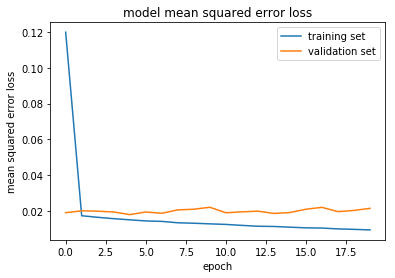

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()